In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import math
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# set the max columns to none
pd.set_option('display.max_columns', None)

# 1. Load data

In [2]:
df = pd.read_csv('../datasets/complete_data/df.csv')
df

,start MTU (UTC),Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
0,2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
1,2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2,2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
3,2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
4,2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
8756,2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
8757,2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0
8758,2022-12-31 22:00:00,119.98,23.56,119.98,4.84,1991.000000,989.0,585.0,69.0,0.0,814.0,2098.000000,13.0,443.0,35.0,183.0,814.0,23.0,1498.0,7.0,25.0,137.0,14.0,539.0,5796.0,0.0,1033.0,504.0,0.0,90.0,0.0,0.0,29.0,2119.0,0.0,5038234.0,1579000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

# 2. Preprocessing

#### 2.1 Indexing

In [4]:
df = df.set_index('start MTU (UTC)')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='start MTU (UTC)', length=8760, freq=None)

#### 2.2 Plotting 'Day-ahead Price BZN|NO1'

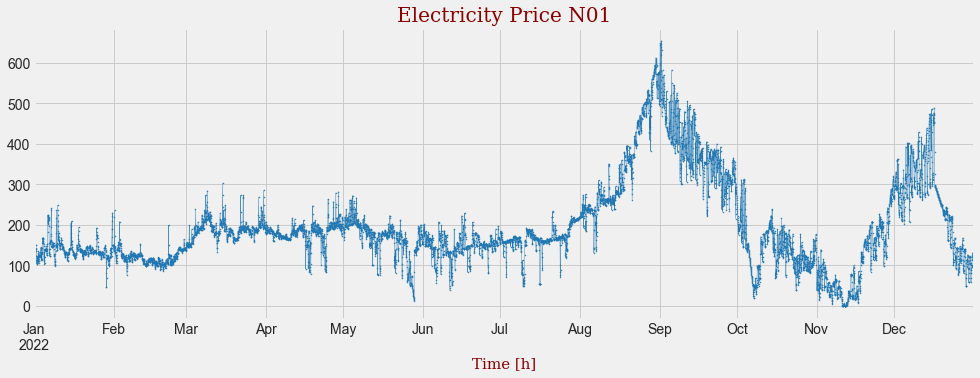

In [5]:
target_column = df['Day-ahead Price [EUR/MWh] BZN|NO1']
target_column_df =  pd.DataFrame(target_column)
target_column.plot( figsize=(15, 5), color=color_pal[0], lw=0.4, marker="." , markersize=1)

font1 = {'family':'serif','color':'darkred','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.title("Electricity Price N01", fontdict = font1)
plt.xlabel("Time [h]", fontdict = font2)
plt.show()

<AxesSubplot:ylabel='Frequency'>

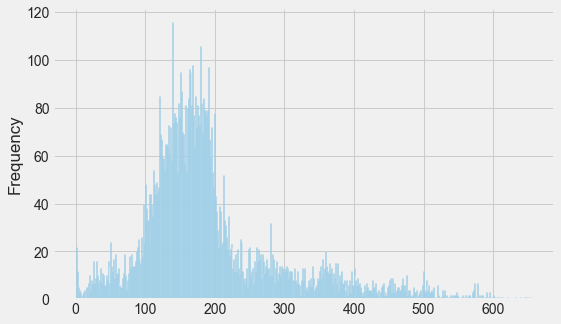

In [6]:
df['Day-ahead Price [EUR/MWh] BZN|NO1'].plot(kind='hist',figsize=(8, 5), bins=500)

In [7]:
df.query( '`Day-ahead Price [EUR/MWh] BZN|NO1` > 100.0 ')

,Day-ahead Price [EUR/MWh] BZN|NO1,Day-ahead Price [EUR/MWh] BZN|NO3,Day-ahead Price [EUR/MWh] BZN|NO5,Day-ahead Price [EUR/MWh] BZN|SE3,Actual Total Load [MW] - BZN|NO5,Hydro Run-of-river and poundage - BZN|NO1,Hydro Water Reservoir - BZN|NO1,Wind Onshore - BZN|NO1,Hydro Pumped Storage Aggregated- BZN|NO2,Hydro Run-of-river and poundage - BZN|NO2,Hydro Water Reservoir - BZN|NO2,Waste - BZN|NO2,Wind Onshore - BZN|NO2,Hydro Pumped Storage Aggregated- BZN|NO3,Hydro Run-of-river and poundage - BZN|NO3,Hydro Water Reservoir - BZN|NO3,Other renewable - BZN|NO3,Wind Onshore - BZN|NO3,Fossil Gas - BZN|NO5,Hydro Pumped Storage Aggregated- BZN|NO5,Hydro Run-of-river and poundage - BZN|NO5,Waste - BZN|NO5,Hydro Water Reservoir - BZN|SE3,Nuclear - BZN|SE3,Solar - BZN|SE3,Wind Onshore - BZN|SE3,CBF BZN|NO2 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO2 [MW],CBF BZN|NO3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO3 [MW],CBF BZN|NO5 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|NO5 [MW],CBF BZN|SE3 > BZN|NO1 [MW],CBF BZN|NO1 > BZN|SE3 [MW],Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|NO3,Stored Energy Value Water Reservoirs and Hydro Storage Plants [MWh] - BZN|SE3
start MTU (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,129.30,41.33,129.30,41.33,1991.000000,878.0,321.0,172.0,1.0,629.0,2153.333333,5.0,244.0,40.0,389.0,2166.0,12.0,219.0,82.0,66.0,227.0,19.0,818.0,5842.0,0.0,999.0,1242.0,0.0,371.0,0.0,594.0,0.0,1065.0,0.0,5688093.0,1656000.0
2022-01-01 01:00:00,132.08,42.18,132.08,42.18,1992.666667,897.0,330.0,151.0,1.0,627.0,2012.000000,4.0,115.0,42.0,390.0,2187.0,12.0,170.0,82.0,66.0,216.0,20.0,818.0,5839.0,0.0,958.0,1222.0,0.0,383.0,0.0,676.0,0.0,927.0,0.0,5688093.0,1656000.0
2022-01-01 02:00:00,111.44,44.37,111.44,44.37,1994.333333,885.0,275.0,160.0,1.0,624.0,1999.555556,4.0,55.0,45.0,405.0,2183.0,12.0,126.0,82.0,65.0,215.0,20.0,838.0,5839.0,0.0,888.0,1679.0,0.0,362.0,0.0,436.0,0.0,748.0,0.0,5688093.0,1656000.0
2022-01-01 03:00:00,112.35,37.67,112.35,37.67,1996.000000,890.0,269.0,148.0,1.0,624.0,1987.111111,4.0,61.0,34.0,393.0,2076.0,12.0,81.0,82.0,65.0,209.0,20.0,842.0,5840.0,0.0,788.0,1668.0,0.0,324.0,0.0,345.0,0.0,918.0,0.0,5688093.0,1656000.0
2022-01-01 04:00:00,113.90,39.70,113.90,39.70,1985.500000,892.0,300.0,147.0,1.0,605.0,1974.666667,4.0,88.0,38.0,398.0,2098.0,11.0,45.0,82.0,65.0,210.0,19.0,841.0,5839.0,0.0,734.0,1697.0,0.0,339.0,0.0,412.0,0.0,826.0,0.0,5688093.0,1656000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,123.61,23.82,123.61,11.57,2128.000000,992.0,621.0,74.0,1.0,823.0,2399.000000,13.0,443.0,34.0,187.0,987.0,23.0,1576.0,7.0,24.0,148.0,14.0,627.0,5796.0,0.0,1499.0,621.0,0.0,146.0,0.0,43.0,0.0,2083.0,0.0,5038234.0,1579000.0
2022-12-31 20:00:00,121.09,23.93,121.09,14.89,2089.000000,980.0,610.0,70.5,1.0,828.0,2265.000000,13.0,443.0,35.0,187.0,997.0,23.0,1548.0,7.0,25.0,135.0,14.0,573.0,5797.0,0.0,1282.0,595.0,0.0,124.0,0.0,24.0,0.0,2097.0,0.0,5038234.0,1579000.0
2022-12-31 21:00:00,120.00,23.75,120.00,9.94,2037.000000,980.0,588.0,67.0,1.0,814.0,2265.000000,13.0,443.0,35.0,182.0,868.0,23.0,1525.0,7.0,25.0,127.0,14.0,544.0,5797.0,0.0,1168.0,608.0,0.0,91.0,0.0,41.0,0.0,2007.0,0.0,5038234.0,1579000.0


#### 2.3 Dropping features

In [8]:
df.drop(['Day-ahead Price [EUR/MWh] BZN|NO5'], axis=1, inplace=True)

#### 2.4 Normalization and scaling

#### 2.5 PCA

#### 2.6 Feature engineering

###### 2.6.1 Create hour feature

In [9]:
def create_features (df):
    df['hour'] = df.index.hour
    return df

###### 2.6.2 Create total import feature

###### 2.6.3 Create total export feature

###### 2.6.4 Create total load feature

#### 2.7  Visualize target and hour feature's relationship

In [10]:
""""
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=df, x='hour', y='Day-ahead Price [EUR/MWh] BZN|NO1')
ax.set_title('Price by Hour')
plt.show
"""

'"\nfig, ax = plt.subplots(figsize=(10, 10))\nsns.boxplot(data=df, x=\'hour\', y=\'Day-ahead Price [EUR/MWh] BZN|NO1\')\nax.set_title(\'Price by Hour\')\nplt.show\n'

# 3. Time series cross validation

### Removing symbols from feature names
We have to remove all symbols from feature names , otherwise get the following error :

"  ValueError: feature_names must be string, and may not contain [, ] or <  "

In [11]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '>'))) else col for col in df.columns.values]
TARGET = 'Day-ahead Price _EUR/MWh_ BZN|NO1'
df.columns

Index(['Day-ahead Price _EUR/MWh_ BZN|NO1',
       'Day-ahead Price _EUR/MWh_ BZN|NO3',
       'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
       'Hydro Run-of-river and poundage - BZN|NO1',
       'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
       'Hydro Pumped Storage Aggregated- BZN|NO2',
       'Hydro Run-of-river and poundage - BZN|NO2',
       'Hydro Water Reservoir - BZN|NO2', 'Waste - BZN|NO2',
       'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
       'Hydro Run-of-river and poundage - BZN|NO3',
       'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
       'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
       'Hydro Pumped Storage Aggregated- BZN|NO5',
       'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
       'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
       'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
       'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZ

### 24 hours rolling example

In [12]:
import pandas as pd
import numpy as np

# create a datetime range for one year with hourly frequency
date_rng = pd.date_range(start='1/1/2022', end='12/31/2022', freq='H')

# create a sample data frame with random values
data = pd.DataFrame(date_rng, columns=['date'])
data['value'] = np.random.randint(0, 100, size=(len(date_rng)))

# convert the data to a 24-hour window
window_size = 24
data_window = data.set_index('date').rolling('{}H'.format(window_size)).sum().reset_index()
data_window = data_window.iloc[window_size - 1::window_size]  # get every 24th row starting from row 23

# display the data
print(data.head())
print(data_window.head())

                 date  value
0 2022-01-01 00:00:00     27
1 2022-01-01 01:00:00     62
2 2022-01-01 02:00:00     34
3 2022-01-01 03:00:00      4
4 2022-01-01 04:00:00     35
                   date   value
23  2022-01-01 23:00:00  1029.0
47  2022-01-02 23:00:00  1246.0
71  2022-01-03 23:00:00  1157.0
95  2022-01-04 23:00:00  1100.0
119 2022-01-05 23:00:00   934.0


## Time Series Split using Sklearn

- We can not train on the future data , this will result in data leakage. We split 12 month into 10 month training , one month validating and one month testing data.

- The validation set is used during development to tune hyperparameters and assess the model's performance, while the test set is used at the end to evaluate the final performance of the model.

In [13]:
FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']

In [14]:
df_limited = df.loc[ '2022-12-21' : '2022-12-31']

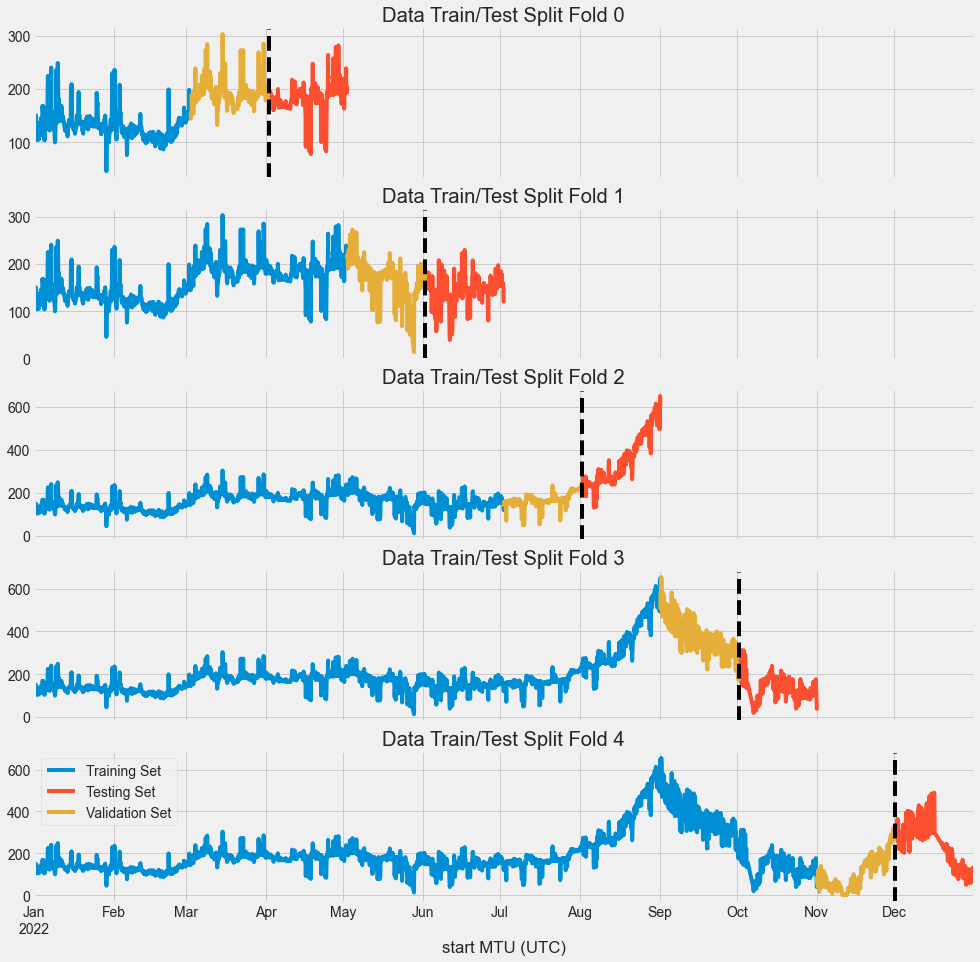

Training set : (7300, 35) . Which is almost 305 days from 365 days
Testing set : (730, 35) . Which is almost 30 days from 365 days
Validation set : (730, 35) . Which is almost 30 days from 365 days


In [15]:
times_series = TimeSeriesSplit(n_splits=5, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in times_series.split(df):
    # Training set is used to fit the model
    train_data = df.iloc[train_idx]
    test_data = df.iloc[val_idx]

    # split the train data into train_data and validation sets,
    # #used to evaluate the model's performance and prevent overwriting.
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

    train_data[TARGET].plot(ax=axs[fold],
                        label='Training Set')

    test_data[TARGET].plot(ax=axs[fold],
                        label='Testing Set')

    val_data[TARGET].plot(ax=axs[fold],
                        label='Validation Set',
                        title=f'Data Train/Test Split Fold {fold}')

    axs[fold].axvline(test_data.index.min(), color='black', ls='--')

    fold += 1


plt.legend(loc="best")
plt.show()

print("Training set :", train_data.shape, ". Which is almost 305 days from 365 days")
print("Testing set :", test_data.shape, ". Which is almost 30 days from 365 days")
print("Validation set :", val_data.shape, ". Which is almost 30 days from 365 days")

# 4. Training Model


In [16]:
FEATURES = [
    'Day-ahead Price _EUR/MWh_ BZN|NO3',
    'Day-ahead Price _EUR/MWh_ BZN|SE3', 'Actual Total Load _MW_ - BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO1',
    'Hydro Water Reservoir - BZN|NO1', 'Wind Onshore - BZN|NO1',
    'Hydro Pumped Storage Aggregated- BZN|NO2',
    'Hydro Run-of-river and poundage - BZN|NO2',
    'Hydro Water Reservoir - BZN|NO2',
    'Waste - BZN|NO2',
    'Wind Onshore - BZN|NO2', 'Hydro Pumped Storage Aggregated- BZN|NO3',
    'Hydro Run-of-river and poundage - BZN|NO3',
    'Hydro Water Reservoir - BZN|NO3', 'Other renewable - BZN|NO3',
    'Wind Onshore - BZN|NO3', 'Fossil Gas - BZN|NO5',
    'Hydro Pumped Storage Aggregated- BZN|NO5',
    'Hydro Run-of-river and poundage - BZN|NO5', 'Waste - BZN|NO5',
    'Hydro Water Reservoir - BZN|SE3', 'Nuclear - BZN|SE3',
    'Solar - BZN|SE3', 'Wind Onshore - BZN|SE3',
    'CBF BZN|NO2 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO2 _MW_',
    'CBF BZN|NO3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO3 _MW_',
    'CBF BZN|NO5 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|NO5 _MW_',
    'CBF BZN|SE3 > BZN|NO1 _MW_', 'CBF BZN|NO1 > BZN|SE3 _MW_',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|NO3',
    'Stored Energy Value Water Reservoirs and Hydro Storage Plants _MWh_ - BZN|SE3']

# define the X and y variables for each set

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]

y_test = test_data[TARGET]

X_valid= val_data[FEATURES]
y_valid = val_data[TARGET]


### Simple regressor and parameters

In [17]:
default_reg = xgb.XGBRegressor (
    max_depth=3,
    learning_rate=0.1,
    n_estimators=1000,
    objective='reg:linear',
    booster='gbtree' ,
    n_jobs=1,
    nthread=None ,
    gamma=0 ,
    min_child_weight=1 ,
    max_delta_step=0 ,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    missing=np.nan)

## (0.10812,3.69 )
basic_reg = xgb.XGBRegressor (
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=27)

### (0.08, 3,23)
second_reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01)

# start timer
start_time = time.time()

default_reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=10)

end_time = time.time()
#print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time))


[16:14:23] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:200.54941	validation_1-rmse:118.88469
[10]	validation_0-rmse:80.43434	validation_1-rmse:69.29380
[20]	validation_0-rmse:42.36267	validation_1-rmse:74.62706
[30]	validation_0-rmse:29.94946	validation_1-rmse:74.43909
[40]	validation_0-rmse:25.87516	validation_1-rmse:72.54391
[50]	validation_0-rmse:23.88612	validation_1-rmse:72.03294
[60]	validation_0-rmse:22.41225	validation_1-rmse:71.90876
[70]	validation_0-rmse:21.19491	validation_1-rmse:71.21127
[80]	validation_0-rmse:20.33861	validation_1-rmse:70.30373
[90]	validation_0-rmse:19.57776	validation_1-rmse:70.19279
[100]	validation_0-rmse:18.97945	validation_1-rmse:69.69511
[110]	validation_0-rmse:18.24645	validation_1-rmse:69.33334
[120]	validation_0-rmse:17.73904	validation_1-rmse:69.57008
[130]	validation_0-rmse:17.37467	validation_1-rmse:69.

## Feature Importance for tuning


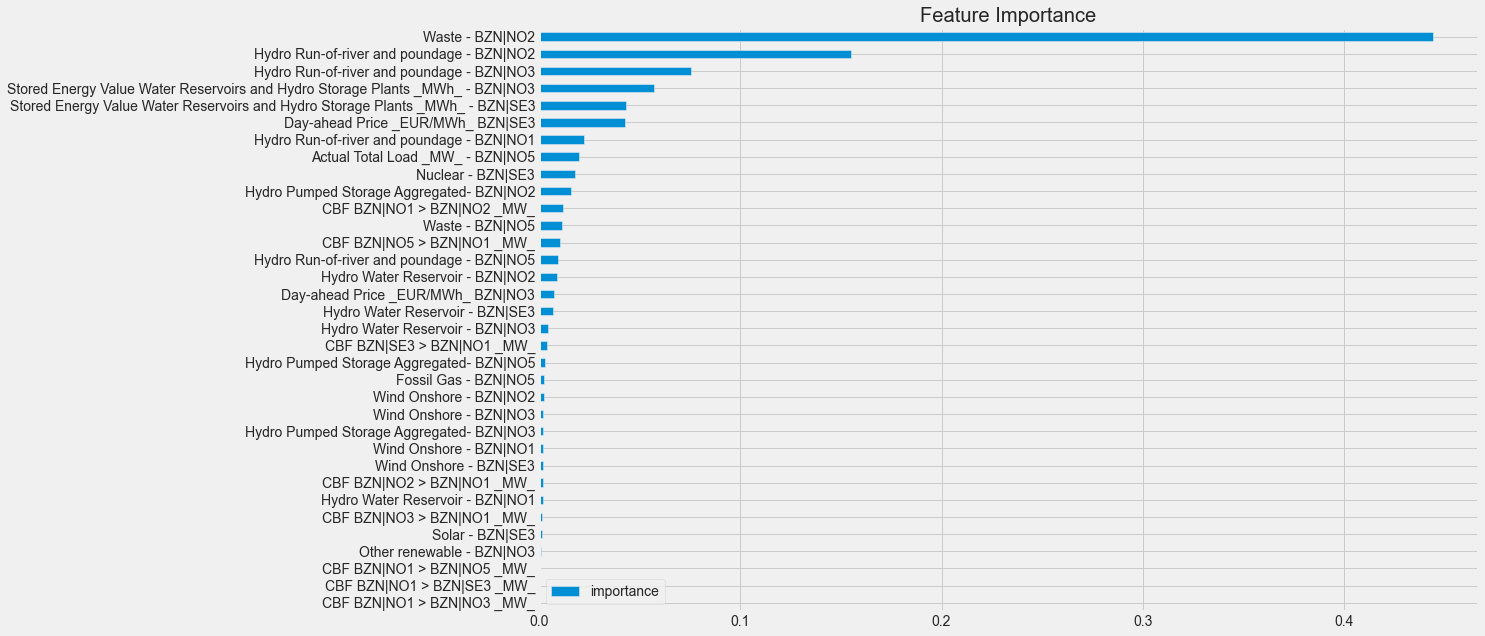

In [18]:
fi = pd.DataFrame(data=default_reg.feature_importances_,
             index=default_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))
plt.show()

# Forecast on validation data
The validation set is used during development to tune hyperparameters and assess the model's performance


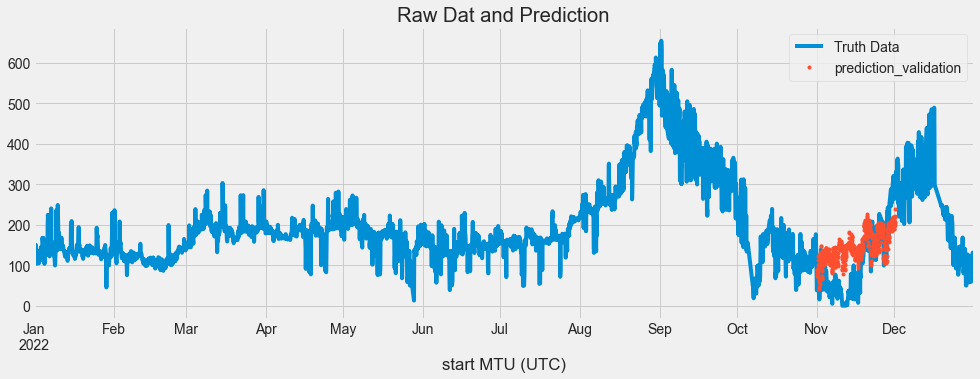

In [19]:

val_data['prediction_validation'] = default_reg.predict(X_valid)
df = df.merge(val_data[['prediction_validation']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_validation'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_validation'])
ax.set_title('Raw Dat and Prediction')
plt.show()

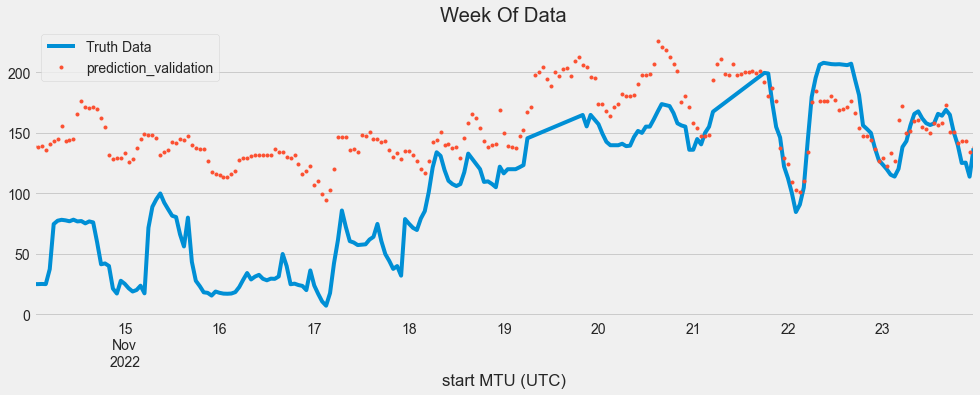

In [20]:
ax = df.loc[(df.index > '2022-11-14') & (df.index < '2022-11-24')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-11-14') & (df.index < '2022-11-24')]['prediction_validation'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_validation'])
plt.show()


# Calculate Error for Validation data
- Look at the worst and best predicted days

In [21]:
val_data['error'] = np.abs(val_data[TARGET] - val_data['prediction_validation'])
val_data['date'] = val_data.index.date
val_data.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-11-12    134.403253
2022-11-13    128.313861
2022-11-10    116.778720
2022-11-11    110.305824
2022-11-16     98.839341
2022-11-14     96.364442
2022-11-09     94.753228
2022-11-15     87.581897
2022-11-30     84.810683
2022-11-17     82.869304
Name: error, dtype: float64

### Score on validation data

In [22]:
score = np.sqrt(mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation']))
print(f'RMSE Score on valid set: {score:0.2f}')


# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean absolute error:            ", mae)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], val_data['prediction_validation'])
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)

RMSE Score on valid set: 71.61
Mean absolute error:             59.0568624240823
Mean squared error:              5127.574678745868
Rood mean squared error:         71.60708539485368


In [23]:
response_range = val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].max() - val_data['Day-ahead Price _EUR/MWh_ BZN|NO1'].min()

# Determine if the RMSE value is a good fit
if rmse < 0.1 * response_range:
    print("The RMSE value of", rmse, "is a good fit for this time series regression model. When the response range is :", response_range)
else:
    print("The RMSE value of", rmse, "indicates poor performance for this time series regression model. When the response range is :", response_range)


The RMSE value of 71.60708539485368 indicates poor performance for this time series regression model. When the response range is : 320.64


### Hyper parameter Tuning

In [24]:
"""
from sklearn.model_selection import GridSearchCV

# define the hyperparameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [3, 5]
}
# perform a grid search over the hyperparameter grid using the validation set

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='accuracy')
grid_search.fit(X_val, y_val)

# select the best hyperparameters from the grid search
best_params = grid_search.best_params_

# fit the XGBoost classifier model with the best hyperparameters on the training set
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

"""

"\nfrom sklearn.model_selection import GridSearchCV\n\n# define the hyperparameter grid to search over\nparam_grid = {\n    'learning_rate': [0.01, 0.1],\n    'n_estimators': [100, 500],\n    'max_depth': [3, 5]\n}\n# perform a grid search over the hyperparameter grid using the validation set\n\ngrid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='accuracy')\ngrid_search.fit(X_val, y_val)\n\n# select the best hyperparameters from the grid search\nbest_params = grid_search.best_params_\n\n# fit the XGBoost classifier model with the best hyperparameters on the training set\nxgb = XGBClassifier(**best_params)\nxgb.fit(X_train, y_train)\n\n"

# Forecast on Test data
the test set is used at the end to evaluate the final performance of the model.

In [25]:
# evaluate the final performance of the model on the test set
test_accuracy = default_reg.score(X_test, y_test)
print(test_accuracy)

0.23353599743911746


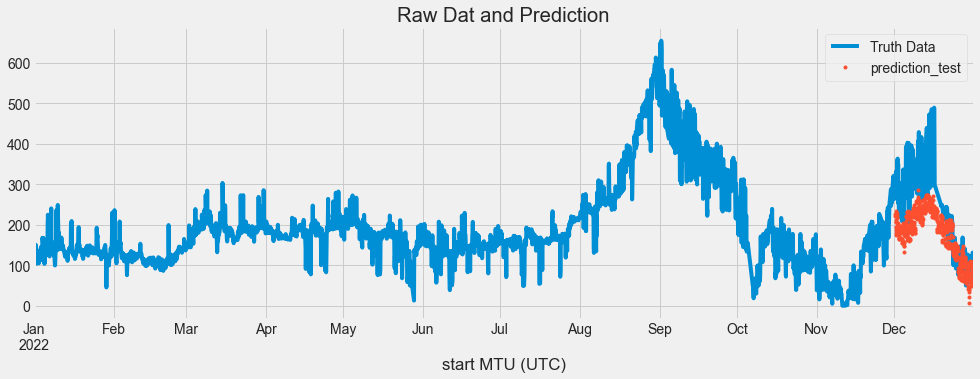

In [26]:
test_data['prediction_test'] = default_reg.predict(X_test)
df = df.merge(test_data[['prediction_test']], how='left', left_index=True, right_index=True)
ax = df[['Day-ahead Price _EUR/MWh_ BZN|NO1']].plot(figsize=(15, 5))
df['prediction_test'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'prediction_test'])
ax.set_title('Raw Dat and Prediction')
plt.show()

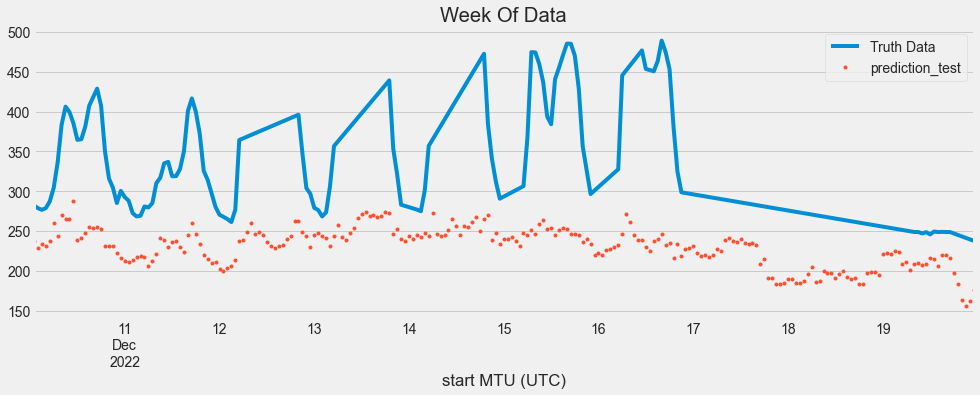

In [27]:
## Showing predicted test data on a week
ax = df.loc[(df.index > '2022-12-10') & (df.index < '2022-12-20')]['Day-ahead Price _EUR/MWh_ BZN|NO1'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2022-12-10') & (df.index < '2022-12-20')]['prediction_test'] \
    .plot(style='.')
plt.legend(['Truth Data','prediction_test'])
plt.show()


# Score (RMSE)

### Score on test

In [28]:

score = np.sqrt(mean_squared_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test']))
print(f'RMSE Score on Test set: {score:0.2f}')

# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test'])
print("Mean absolute error:            ", mae)

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(test_data['Day-ahead Price _EUR/MWh_ BZN|NO1'], test_data['prediction_test'])
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Rood mean squared error:        ", rmse)

RMSE Score on Test set: 90.32
Mean absolute error:             72.27173811241046
Mean squared error:              8157.167259478852
Rood mean squared error:         90.31703748174456


# Calculate Error
- Look at the worst and best predicted days


In [29]:
test_data['error'] = np.abs(test_data[TARGET] - test_data['prediction_test'])
test_data['date'] = test_data.index.date
test_data.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-12-16    161.309006
2022-12-15    142.715163
2022-12-08    124.568069
2022-12-14    121.951327
2022-12-06    121.754141
2022-12-07    115.675913
2022-12-12    113.853470
2022-12-09    112.747034
2022-12-02    111.927968
2022-12-01    107.993248
Name: error, dtype: float64

## ## Feature Importance final results

In [30]:
"""
fi = pd.DataFrame(data=default_reg.feature_importances_,
             index=default_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))
plt.show()
"""

"\nfi = pd.DataFrame(data=default_reg.feature_importances_,\n             index=default_reg.feature_names_in_,\n             columns=['importance'])\nfi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize= (15,10))\nplt.show()\n"

# 5. Predicting 24 hours time horizon

Once you're satisfied with the model's performance on the validation set, you can then retrain the model using the full dataset (i.e., both the training set and the validation set) and make predictions on new, unseen data.